In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

print(sns.__version__)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

0.11.0


In [111]:
dset='cfr'
meta_date = '200617'
cfr_data_root = os.path.normpath('/mnt/obi0/andreas/data/cfr')
tfr_dir = os.path.join(cfr_data_root, 'tfr_'+meta_date, dset)
image_dir = os.path.join(cfr_data_root, 'images')

meta_dir = os.path.join(cfr_data_root, 'metadata_'+meta_date)
print(tfr_dir)

/mnt/obi0/andreas/data/cfr/tfr_200617/cfr


In [6]:
train_files = sorted(glob.glob(os.path.join(tfr_dir, dset+'_a4c_train_'+meta_date+'_*.parquet')))
eval_files = sorted(glob.glob(os.path.join(tfr_dir, dset+'_a4c_eval_'+meta_date+'_*.parquet')))
test_files = sorted(glob.glob(os.path.join(tfr_dir, dset+'_a4c_test_'+meta_date+'_*.parquet')))
file_list = train_files + eval_files + test_files
len(file_list)
df_list = []
for file in file_list:
    df_list.append(pd.read_parquet(file))
df = pd.concat(df_list, axis=0, ignore_index=True)
display(df.head(2))

,rest_global_mbf,stress_global_mbf,global_cfr_calc,post-2018,tracer_obi,mrn,study,pet_date,echo_date,petmrn_identifier,days_post_pet,pet_measurement,difference(days),filename,dir,datetime,file_base,identifier,frame_time,number_of_frames,heart_rate,deltaX,deltaY,a2c,a2c_laocc,...,apex,other,plax_far,plax_lac,plax_laz,plax_laz_ao,plax_plax,psax_avz,psax_az,psax_mv,psax_pap,rvinf,subcostal,suprasternal,year_month,study_full_time,institution,model,manufacturer,max_view,sum_views,dset_mode,rate,dur,im_array_shape
0,0.869,1.427,1.642117,0,ammonia,5145784,4b7e489da6cc10de_4903a5864e6e322011843a369e35,2013-05-28,2013-08-09,5145784_2013-05-28,73,1.0,73.0,4b7e489da6cc10de_4903a5864e6e322011843a369e35_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b7e/4b7e489da...,2013-08-09 14:31:53,4b7e489da6cc10de_4903a5864e6e322011843a369e35_...,4b7e489da6cc10de_4903a5864e6e322011843a369e35_...,33.333,91.0,0.0,0.048411,0.048411,2.782236e-07,4.344485e-08,...,5.312065e-07,9.128748e-08,9.962714e-09,4.387772e-06,6.449753e-07,2.332877e-08,4.007432e-05,5.262363e-05,1.662658e-07,1.474171e-06,3.452945e-04,9.458074e-03,3.875024e-07,3.108904e-07,2013.0,20130809143153,BWH,iE33,Philips Medical Systems,a4c,1.0,train,30.0,3.033303,"[218, 290, 40]"
1,2.219,1.647,0.742226,0,rubidium,9035155,4b7293dc45bdc79f_4903a444c3016869b4dd995be1a0,2007-12-13,2007-09-06,9035155_2007-12-13,-98,1.0,98.0,4b7293dc45bdc79f_4903a444c3016869b4dd995be1a0_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b72/4b7293dc4...,2007-09-06 15:53:21,4b7293dc45bdc79f_4903a444c3016869b4dd995be1a0_...,4b7293dc45bdc79f_4903a444c3016869b4dd995be1a0_...,33.333,91.0,83.0,0.035325,0.035325,1.723178e-11,1.789704e-11,...,2.125550e-11,2.645912e-13,5.548284e-13,3.722441e-13,2.429788e-11,4.471338e-16,3.166167e-14,9.426915e-14,7.312011e-13,2.482137e-13,1.046167e-13,6.328398e-11,2.654915e-17,4.541407e-15,2007.0,20070906155321,BWH,iE33,Philips Medical Systems,a4c,1.0,train,30.0,3.033303,"[159, 212, 40]"


In [58]:
# Limit to unique PET studies
dfpet = df.drop_duplicates(subset='petmrn_identifier', keep='first')
dfpet = dfpet[dfpet['tracer_obi'].isin(['ammonia', 'rubidium'])].reset_index(drop=True)
dfpet = dfpet.drop(['rest_global_mbf'], axis=1).\
                rename(columns={'stress_global_mbf': 'measuredMBF',
                                'global_cfr_calc': 'measuredCFR'})
dfpet['id']=dfpet.index
dfpet_cols = ['id', 'petmrn_identifier', 'tracer_obi', 'measuredMBF', 'measuredCFR']
dfpet = dfpet[dfpet_cols]
display(dfpet.head(3))

# Now, convert to long format
dfpet_long = pd.wide_to_long(dfpet, stubnames='measured', i='petmrn_identifier', j='variable', suffix='\\w+').\
                reset_index(drop=False)
display(dfpet_long.head(3))

,id,petmrn_identifier,tracer_obi,measuredMBF,measuredCFR
0,0,5145784_2013-05-28,ammonia,1.427,1.642117
1,1,9035155_2007-12-13,rubidium,1.647,0.742226
2,2,19847102_2011-12-29,ammonia,1.092,2.100000


,petmrn_identifier,variable,tracer_obi,id,measured
0,5145784_2013-05-28,MBF,ammonia,0,1.427
1,9035155_2007-12-13,MBF,rubidium,1,1.647
2,19847102_2011-12-29,MBF,ammonia,2,1.092


In [113]:
SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

sns.set_style("whitegrid")

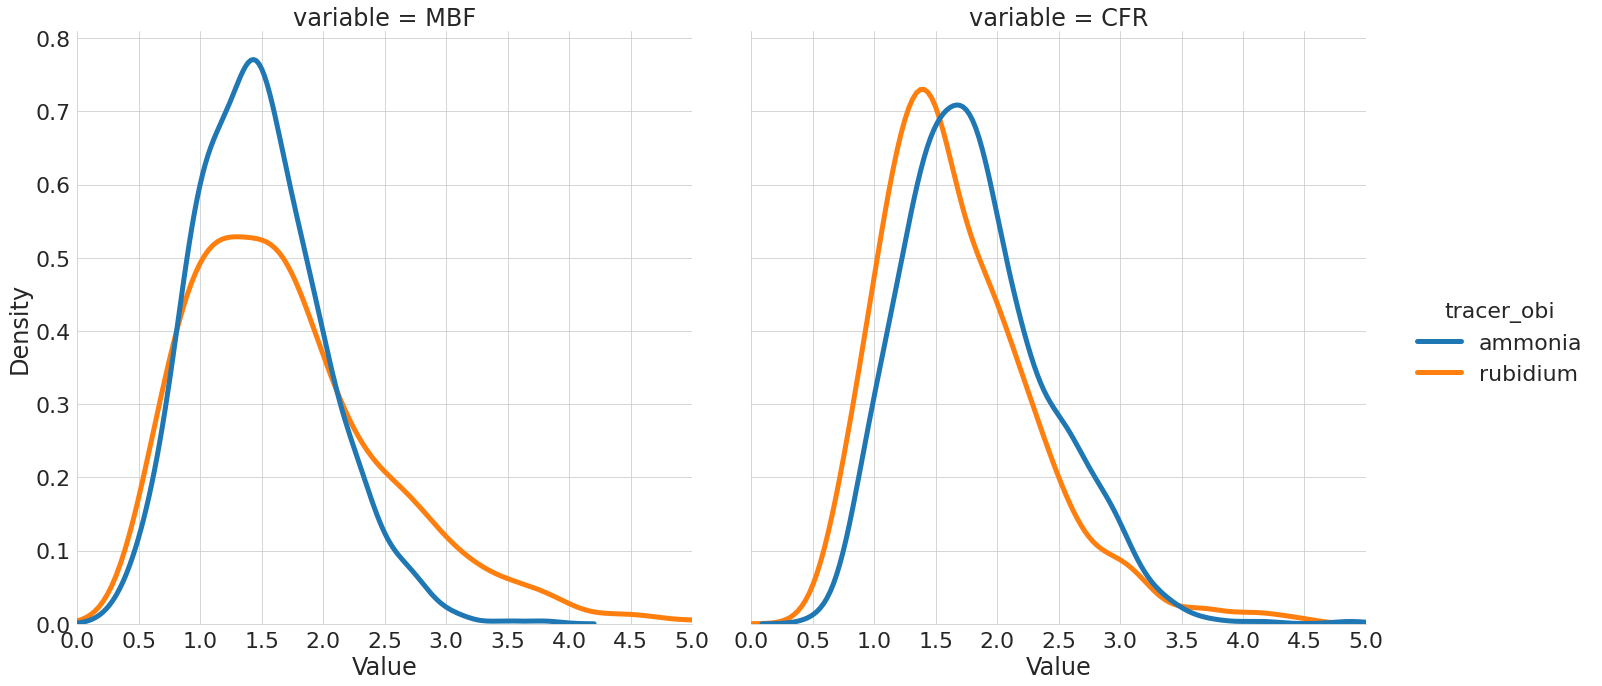

In [143]:
facet = sns.displot(data=dfpet_long, x='measured', y=None, hue='tracer_obi', 
                    col='variable', kind='kde', height=10, hue_order=['ammonia', 'rubidium'],
                    col_order=['MBF', 'CFR'], linewidth=5,
                    common_norm=False, legend=True)


facet.set(xlim=(0, 5), xticks=np.arange(0, 5.25, 0.5))
#         ylim=(0, 1.0),yticks=np.arange(0, 1.1, 0.2))

facet.set_axis_labels('Value', 'Density')
facet.tight_layout()

facet.despine(left=True)
#facet.add_legend()
#facet.fig.get_axes()[1].legend(loc='upper right')

filename = 'mbf_cfr_normalized_kde.png'
save_file = os.path.join(image_dir, filename)
plt.savefig(save_file, dpi=300, bbox_inches='tight')

plt.show()

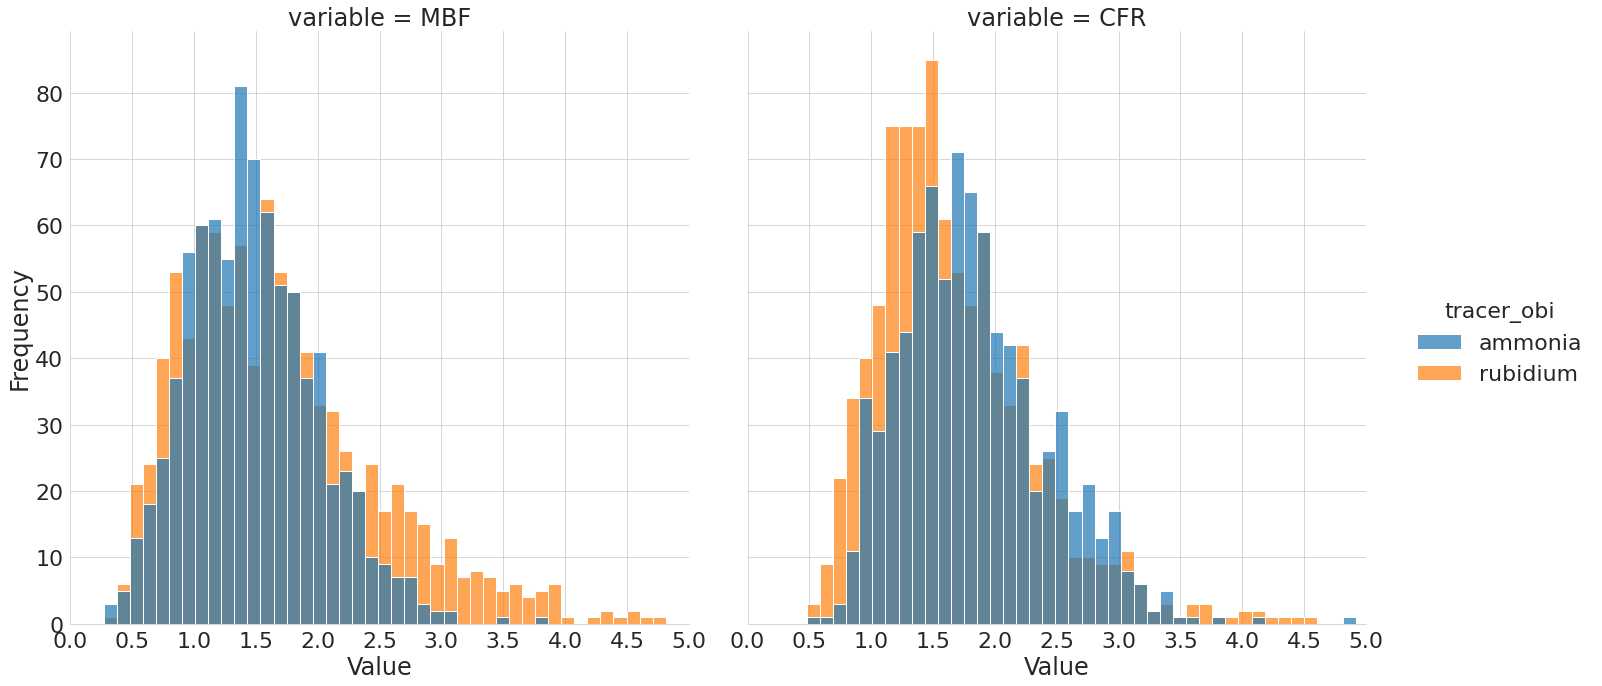

In [144]:
facet = sns.displot(data=dfpet_long, x='measured', y=None, hue='tracer_obi', 
                    col='variable', kind='hist', height=10, hue_order=['ammonia', 'rubidium'],
                    col_order=['MBF', 'CFR'], legend=True, alpha=0.7)


facet.set(xlim=(0, 5), xticks=np.arange(0, 5.25, 0.5))
#         ylim=(0, 1.0),yticks=np.arange(0, 1.1, 0.2))

facet.set_axis_labels('Value', 'Frequency')
facet.tight_layout()

facet.despine(left=True)
#facet.add_legend()
#facet.fig.get_axes()[1].legend(loc='upper right')

filename = 'mbf_cfr_hist.png'
save_file = os.path.join(image_dir, filename)
plt.savefig(save_file, dpi=300, bbox_inches='tight')

plt.show()